In [2]:
from tensorflow.keras.utils import load_img, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import EfficientNetB7
import tensorflow as tf

from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline

from glob import glob
import pandas as pd
import numpy as np
import joblib
import time

seed = 101

In [3]:
# Load the MovileNetV2 model with imagenet weights. Specify the input shape to be a multiple of the standard image size and grayscale.

model = EfficientNetB7(
    input_shape=(256,256,3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
model.trainable = False

2023-02-05 22:06:18.399891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-05 22:06:18.399980: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 22:06:18.400000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-02-05 22:06:18.400235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# images = np.stack([np.array(load_img(fname)) for fname in fnames[:100]])
images = image_dataset_from_directory(
    directory='images_007/',
    labels=None,
    shuffle=False,
    image_size=(256,256),
    interpolation='bicubic')

Found 10000 files belonging to 1 classes.


In [5]:
X = model.predict(images)

313/313 [==============================] - 1407s 4s/step


Persist these vector to a joblib file.

In [6]:
joblib.dump(X, 'EfficientNetB7Max.joblib')

['EfficientNetB7Max.joblib']

Train a one-class SVM and see if I can tune the parameters to get a more coherent result.

In [7]:
gamma = 1 / (X.shape[1]*X.var())
gamma

0.000270710291493552

In [8]:
clf = OneClassSVM(nu=0.01, gamma=gamma, kernel='rbf')
start = time.time()
y_pred = clf.fit_predict(X)
end = time.time()
print('Time to train a OneClassSVM: %0.2fs' % (end-start))

Time to train a OneClassSVM: 3.67s


In [9]:
transform = Nystroem(kernel='rbf', n_components=100, gamma=gamma)
clf = SGDOneClassSVM(nu=0.01, random_state=seed)
pipe = Pipeline([('transform',transform),('clf',clf)])
start = time.time()
y_pred = pipe.fit_predict(X)
end = time.time()
print('Time to train a OneClassSVM: %0.2fs' % (end-start))

Time to train a OneClassSVM: 0.17s


In [10]:
pd.value_counts(y_pred)

 1    9919
-1      81
dtype: int64

In [11]:
df = pd.DataFrame({
    'fname':images.file_paths,
    'y_pred':y_pred
})
df.head()

,fname,y_pred
0,images_007/images/00013774_026.png,1
1,images_007/images/00013774_027.png,1
2,images_007/images/00013774_028.png,1
3,images_007/images/00013774_029.png,1
4,images_007/images/00013774_030.png,1


In [12]:
df[df['y_pred']==-1].sample(5, random_state=seed)

,fname,y_pred
3555,images_007/images/00014474_002.png,-1
7384,images_007/images/00015439_001.png,-1
2069,images_007/images/00014174_022.png,-1
3554,images_007/images/00014474_001.png,-1
1907,images_007/images/00014141_002.png,-1


In [13]:
df[df['y_pred']==1].sample(5, random_state=seed)

,fname,y_pred
3455,images_007/images/00014454_000.png,1
8523,images_007/images/00015669_005.png,1
6912,images_007/images/00015313_008.png,1
2142,images_007/images/00014193_000.png,1
6590,images_007/images/00015202_000.png,1


Look at a normal image.

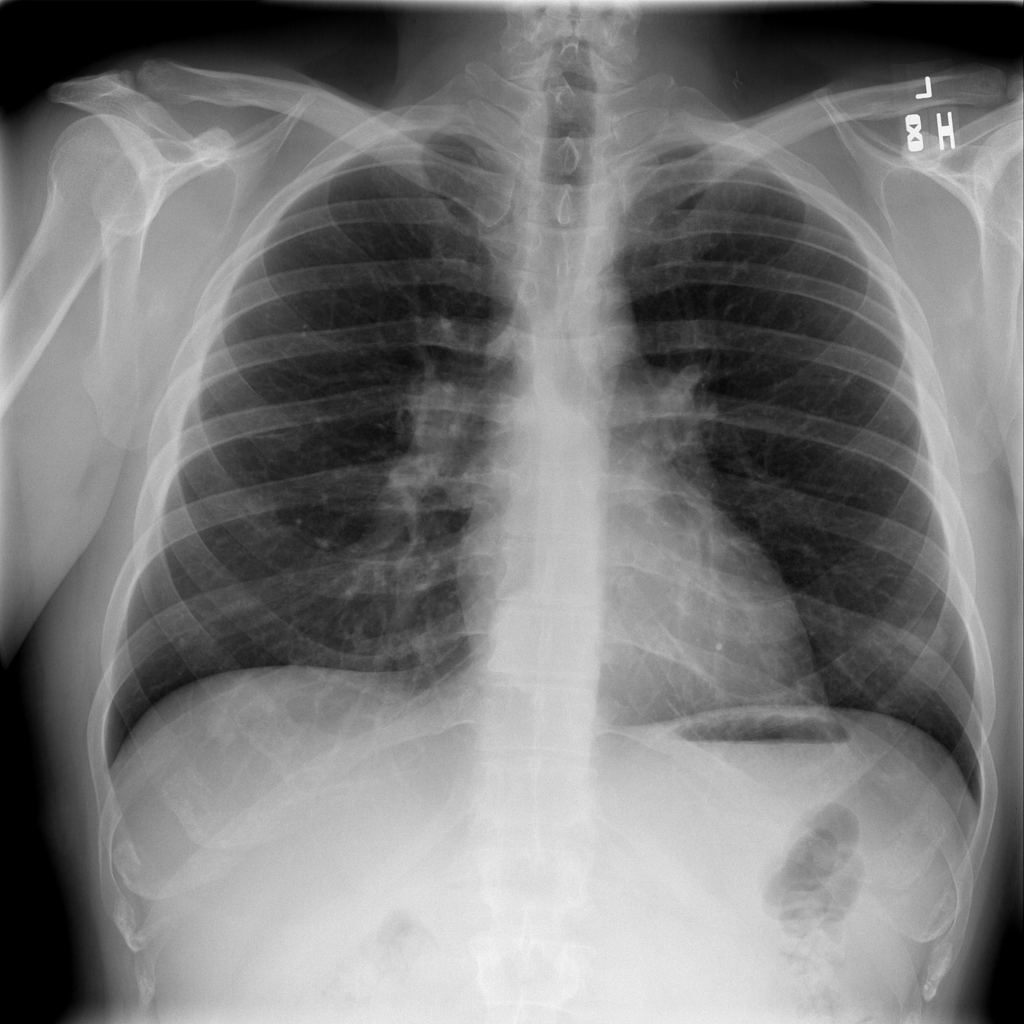

In [30]:
load_img(images.file_paths[3455])

Look at some example outliers.

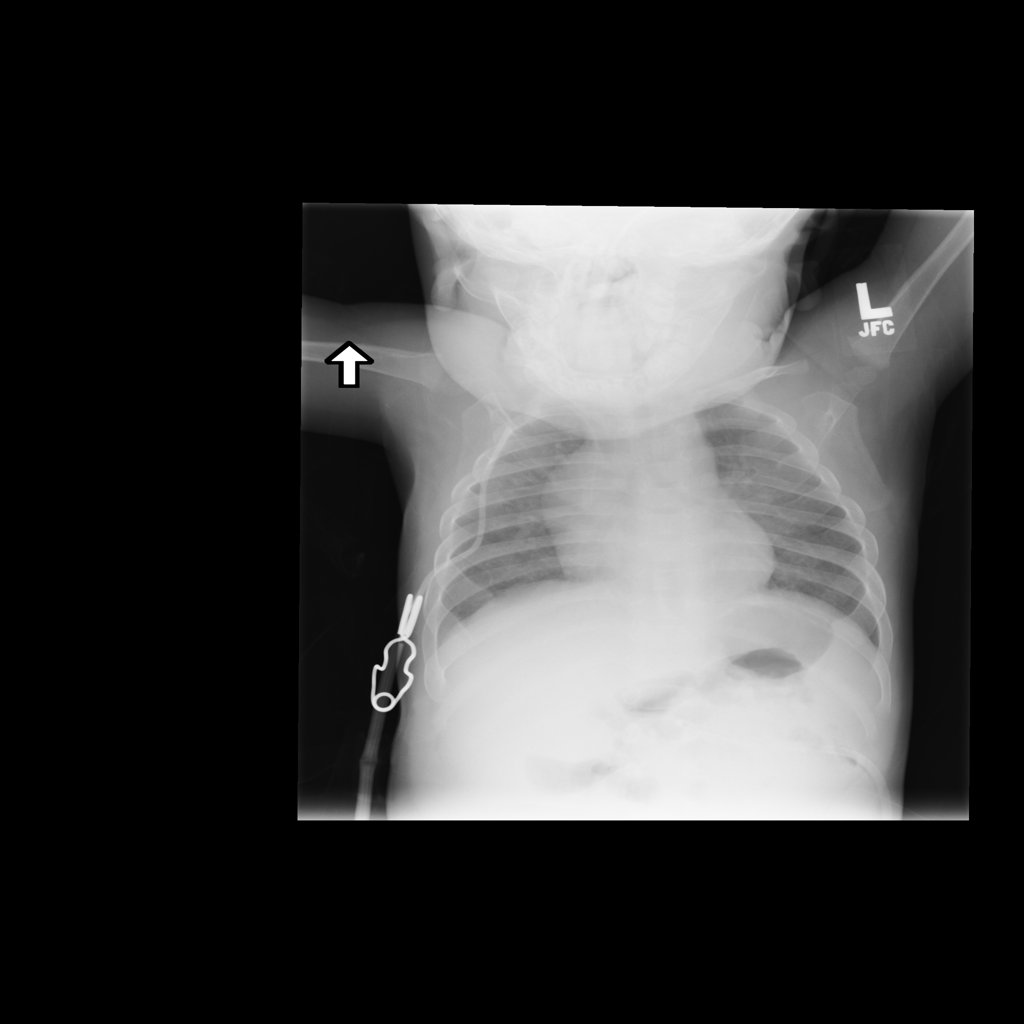

In [29]:
load_img(images.file_paths[3555])

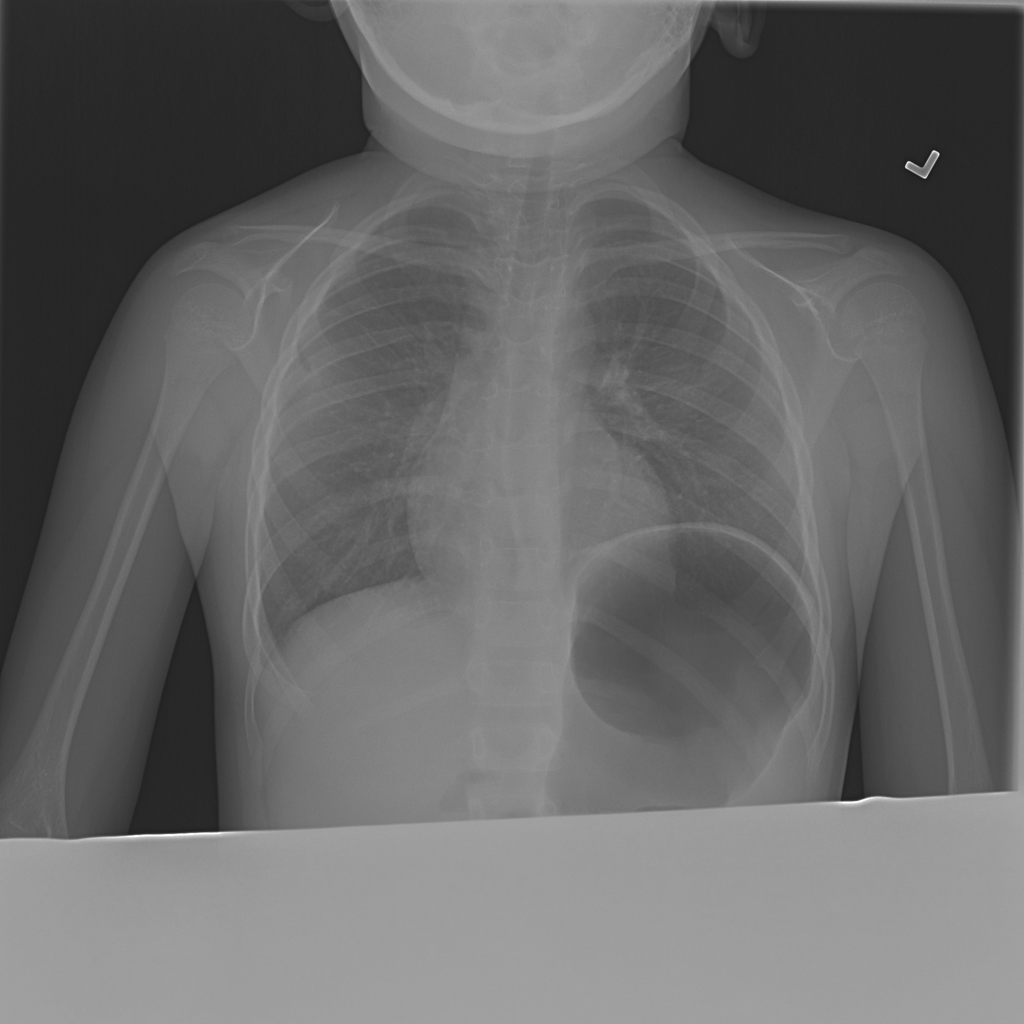

In [31]:
load_img(images.file_paths[3554])